In [8]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np

import sigpy as sp
import sigpy.plot as pl
import seaborn as sns
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import pingouin as pg
import scikit_posthocs as sp

from scipy.signal import argrelextrema

import sys
sys.path.append("/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='darkgrid', palette='Set2')

In [17]:
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img>0] = 1
    edges_img.dtype = float
    edges_img[edges_img ==0] = 'nan'
    return edges_img

In [18]:
# Load in Spatial Gradients

volunteers=[1,2,3,4,5,7,8,9,10,11]
slope_m0 = np.zeros((128, 128, 6, 4, 5, 8, 10))
slope_m1 = np.zeros((128, 128, 6, 4, 5, 8, 10))
slope_m2 = np.zeros((128, 128, 6, 4, 5, 8, 10))

for vv in range(10):
    volunteer = str(volunteers[vv])
    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
    savename = os.path.join(inpath,'M0_slope.npy')
    slope_m0[:,:,:,:,:,:,vv] = np.load(savename)

    savename = os.path.join(inpath,'M1_slope.npy')
    slope_m1[:,:,:,:,:,:,vv] = np.load(savename)
    
    savename = os.path.join(inpath,'M2_slope.npy')
    slope_m2[:,:,:,:,:,:,vv] = np.load(savename)
    

In [19]:
atten_m0 = abs(np.sinc((np.nanmean(slope_m0,axis = -3)) *2*2/2))
atten_m1 = abs(np.sinc((np.nanmean(slope_m1,axis = -3)) *2*2/2))
atten_m2 = abs(np.sinc((np.nanmean(slope_m2,axis = -3)) *2*2/2))

atten_m0.shape

<ipython-input-19-82fe4e99692a>:1: RuntimeWarning: Mean of empty slice
  atten_m0 = abs(np.sinc((np.nanmean(slope_m0,axis = -3)) *2*2/2))
<ipython-input-19-82fe4e99692a>:2: RuntimeWarning: Mean of empty slice
  atten_m1 = abs(np.sinc((np.nanmean(slope_m1,axis = -3)) *2*2/2))
<ipython-input-19-82fe4e99692a>:3: RuntimeWarning: Mean of empty slice
  atten_m2 = abs(np.sinc((np.nanmean(slope_m2,axis = -3)) *2*2/2))


(128, 128, 6, 4, 8, 10)

# Load in Magnitude, Phase, and Mask

In [20]:
volunteers=[1,2,3,4,5,7,8,9,10,11]

M0_mag = np.zeros((128,128,6,4,5,8,10))
M1_mag = np.zeros((128,128,6,4,5,8,10))
M2_mag = np.zeros((128,128,6,4,5,8,10))

M0_phs = np.zeros((128,128,6,4,5,8,10))
M1_phs = np.zeros((128,128,6,4,5,8,10))
M2_phs = np.zeros((128,128,6,4,5,8,10))

for vv in range(10):
    # For each volunteer 



    volunteer = str(volunteers[vv])
    print(volunteer, end = ' ')
    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    num = 0
    for num in range(3):
        nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
        bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
        bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
        mask_files   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
        

        nii_files.sort()
        bval_files.sort()
        bvec_files.sort()
        mask_files.sort()
        
        data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
        bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
        bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
        mask,header =  nrrd.read(os.path.join(inpath, mask_files[num]))
        
        mask = mask.astype('float')
        mask[mask==0] = np.nan
        
        
        data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)
        
        ims = np.stack((data1[:,:,:,:,:5],data1[:,:,:,:,5:10],data1[:,:,:,:,10:15],
                            data1[:,:,:,:,15:20],data1[:,:,:,:,20:25],data1[:,:,:,:,25:30],
                            data1[:,:,:,:,30:35],data1[:,:,:,:,35:40]),axis = -1)  
            
        
        mag = abs(ims)
        phs = np.angle(ims)

        
        if num == 0:
            M0_mag[:,:,:,:,:,:,vv] = mag #* mask_rep
            M0_phs[:,:,:,:,:,:,vv] = phs #*mask_rep

        if num == 1:
            M1_mag[:,:,:,:,:,:,vv] = mag #* mask_rep
            M1_phs[:,:,:,:,:,:,vv] = phs #*mask_rep

            
        if num == 2:
            M2_mag[:,:,:,:,:,:,vv] = mag #* mask_rep
            M2_phs[:,:,:,:,:,:,vv] = phs #*mask_rep

# One data structure of complex dataset 
im_M0 = M0_mag * np.exp(1j*M0_phs)
im_M1 = M1_mag * np.exp(1j*M1_phs)
im_M2 = M2_mag * np.exp(1j*M2_phs)

del M0_mag,M1_mag,M2_mag
del M0_phs,M1_phs,M2_phs

1 2 3 4 5 7 8 9 10 11 

In [21]:
# Load in Mask

volunteers=[1,2,3,4,5,7,8,9,10,11]
import cv2
M0_mask_new = np.zeros((128,128,6,10))
M1_mask_new = np.zeros((128,128,6,10))
M2_mask_new = np.zeros((128,128,6,10))
for vv in range(10):
    # For each volunteer 
    M0_mag = np.zeros((128,128,6,4,5,8))
    M1_mag = np.zeros((128,128,6,4,5,8))
    M2_mag = np.zeros((128,128,6,4,5,8))

    M0_phs = np.zeros((128,128,6,4,5,8))
    M1_phs = np.zeros((128,128,6,4,5,8))
    M2_phs = np.zeros((128,128,6,4,5,8))


    volunteer = str(volunteers[vv])
    print(volunteer, end = ' ')
    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    num = 0
    for num in range(3):
        mask_end   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
        mask_end.sort()
        mask_end,header =  nrrd.read(os.path.join(inpath, mask_end[num]))
        mask = mask_end
        mask = mask.astype('float')
        mask[mask==0] = np.nan

        if num ==0:
            M0_mask_new[:,:,:,vv] = mask
        if num ==1:
            M1_mask_new[:,:,:,vv] = mask
        if num ==2:
            M2_mask_new[:,:,:,vv] = mask





M0_mask = M0_mask_new
M1_mask = M1_mask_new
M2_mask = M2_mask_new
M2_mask.shape

1 2 3 4 5 7 8 9 10 11 

(128, 128, 6, 10)

# Complex Averaging and Magnitdue Averaging

In [22]:
sys.path.append("../../")
from DataSorting import *
from Averaging import *
from DWI import *
from Colormaps import *

cDTI_cmaps     = cDTI_Colormaps_Generator()


In [25]:



averaged_complex_M0 = np.zeros((128,128,6,4,8,10),dtype = 'complex128')
averaged_complex_M1 = np.zeros((128,128,6,4,8,10),dtype = 'complex128')
averaged_complex_M2 = np.zeros((128,128,6,4,8,10),dtype = 'complex128')

adc_complex_M0 = np.zeros((128,128,6,8,10))
adc_complex_M1 = np.zeros((128,128,6,8,10))
adc_complex_M2 = np.zeros((128,128,6,8,10))

for vv in range(10):
    for ii in range(8):
        [avg,_,_,_]= average(im_M0[:,:,:,:,:,ii,vv],[],[],operation_type='Complex')
        averaged_complex_M0[:,:,:,:,ii,vv] = np.squeeze(avg)
        
        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_complex_M0[:,:,:,ii,vv] = adc[0]['ADC']

        [avg,_,_,_ ]= average(im_M1[:,:,:,:,:,ii,vv],[],[],operation_type='Complex')
        averaged_complex_M1[:,:,:,:,ii,vv] = np.squeeze(avg)

        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_complex_M1[:,:,:,ii,vv] = adc[0]['ADC']

        [avg,_,_,_ ]= average(im_M2[:,:,:,:,:,ii,vv],[],[],operation_type='Complex')
        averaged_complex_M2[:,:,:,:,ii,vv] = np.squeeze(avg)

        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_complex_M2[:,:,:,ii,vv] = adc[0]['ADC']


"""

averaged_mag_M0 = np.zeros((128,128,6,4,8,10),dtype = 'complex128')
averaged_mag_M1 = np.zeros((128,128,6,4,8,10),dtype = 'complex128')
averaged_mag_M2 = np.zeros((128,128,6,4,8,10),dtype = 'complex128')

adc_mag_M0 = np.zeros((128,128,6,8,10))
adc_mag_M1 = np.zeros((128,128,6,8,10))
adc_mag_M2 = np.zeros((128,128,6,8,10))

for vv in range(10):
    for ii in range(8):
        [avg,_,_ ]= average(im_M0[:,:,:,:,:,ii,vv],[],[],operation_type='Magnitude')
        averaged_mag_M0[:,:,:,:,ii,vv] = np.squeeze(avg)
        
        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_mag_M0[:,:,:,ii,vv] = adc[0]['ADC']

        [avg,_,_ ]= average(im_M1[:,:,:,:,:,ii,vv],[],[],operation_type='Magnitude')
        averaged_mag_M1[:,:,:,:,ii,vv] = np.squeeze(avg)

        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_mag_M1[:,:,:,ii,vv] = adc[0]['ADC']

        [avg,_,_ ]= average(im_M2[:,:,:,:,:,ii,vv],[],[],operation_type='Magnitude')
        averaged_mag_M2[:,:,:,:,ii,vv] = np.squeeze(avg)

        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)
        adc_mag_M2[:,:,:,ii,vv] = adc[0]['ADC']

"""

../../DWI.py:45: RuntimeWarning: divide by zero encountered in log
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
../../DWI.py:45: RuntimeWarning: invalid value encountered in log
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
../../DWI.py:46: RuntimeWarning: divide by zero encountered in log
  D_yy                             = -(1 / b) * np.log(S_y / S_0)                                                             # Calculate y diffusion coefficient
../../DWI.py:46: RuntimeWarning: invalid value encountered in log
  D_yy                             = -(1 / b) * np.log(S_y / S_0)                                                             # Calculate y diffusion coefficient
../../DWI.py:47: RuntimeWarning: divide by zero encountered in log
  D_zz             

"\n\naveraged_mag_M0 = np.zeros((128,128,6,4,8,10),dtype = 'complex128')\naveraged_mag_M1 = np.zeros((128,128,6,4,8,10),dtype = 'complex128')\naveraged_mag_M2 = np.zeros((128,128,6,4,8,10),dtype = 'complex128')\n\nadc_mag_M0 = np.zeros((128,128,6,8,10))\nadc_mag_M1 = np.zeros((128,128,6,8,10))\nadc_mag_M2 = np.zeros((128,128,6,8,10))\n\nfor vv in range(10):\n    for ii in range(8):\n        [avg,_,_ ]= average(im_M0[:,:,:,:,:,ii,vv],[],[],operation_type='Magnitude')\n        averaged_mag_M0[:,:,:,:,ii,vv] = np.squeeze(avg)\n        \n        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)\n        adc_mag_M0[:,:,:,ii,vv] = adc[0]['ADC']\n\n        [avg,_,_ ]= average(im_M1[:,:,:,:,:,ii,vv],[],[],operation_type='Magnitude')\n        averaged_mag_M1[:,:,:,:,ii,vv] = np.squeeze(avg)\n\n        adc = DWI_recon(np.real(avg),bvals_sort,bvecs_sort)\n        adc_mag_M1[:,:,:,ii,vv] = adc[0]['ADC']\n\n        [avg,_,_ ]= average(im_M2[:,:,:,:,:,ii,vv],[],[],operation_type='Magnitude')\n    

In [24]:
average(im_M0[:,:,:,:,:,ii,vv],[],[],operation_type='Complex')

(128, 128, 6, 4, 5, 8, 10)

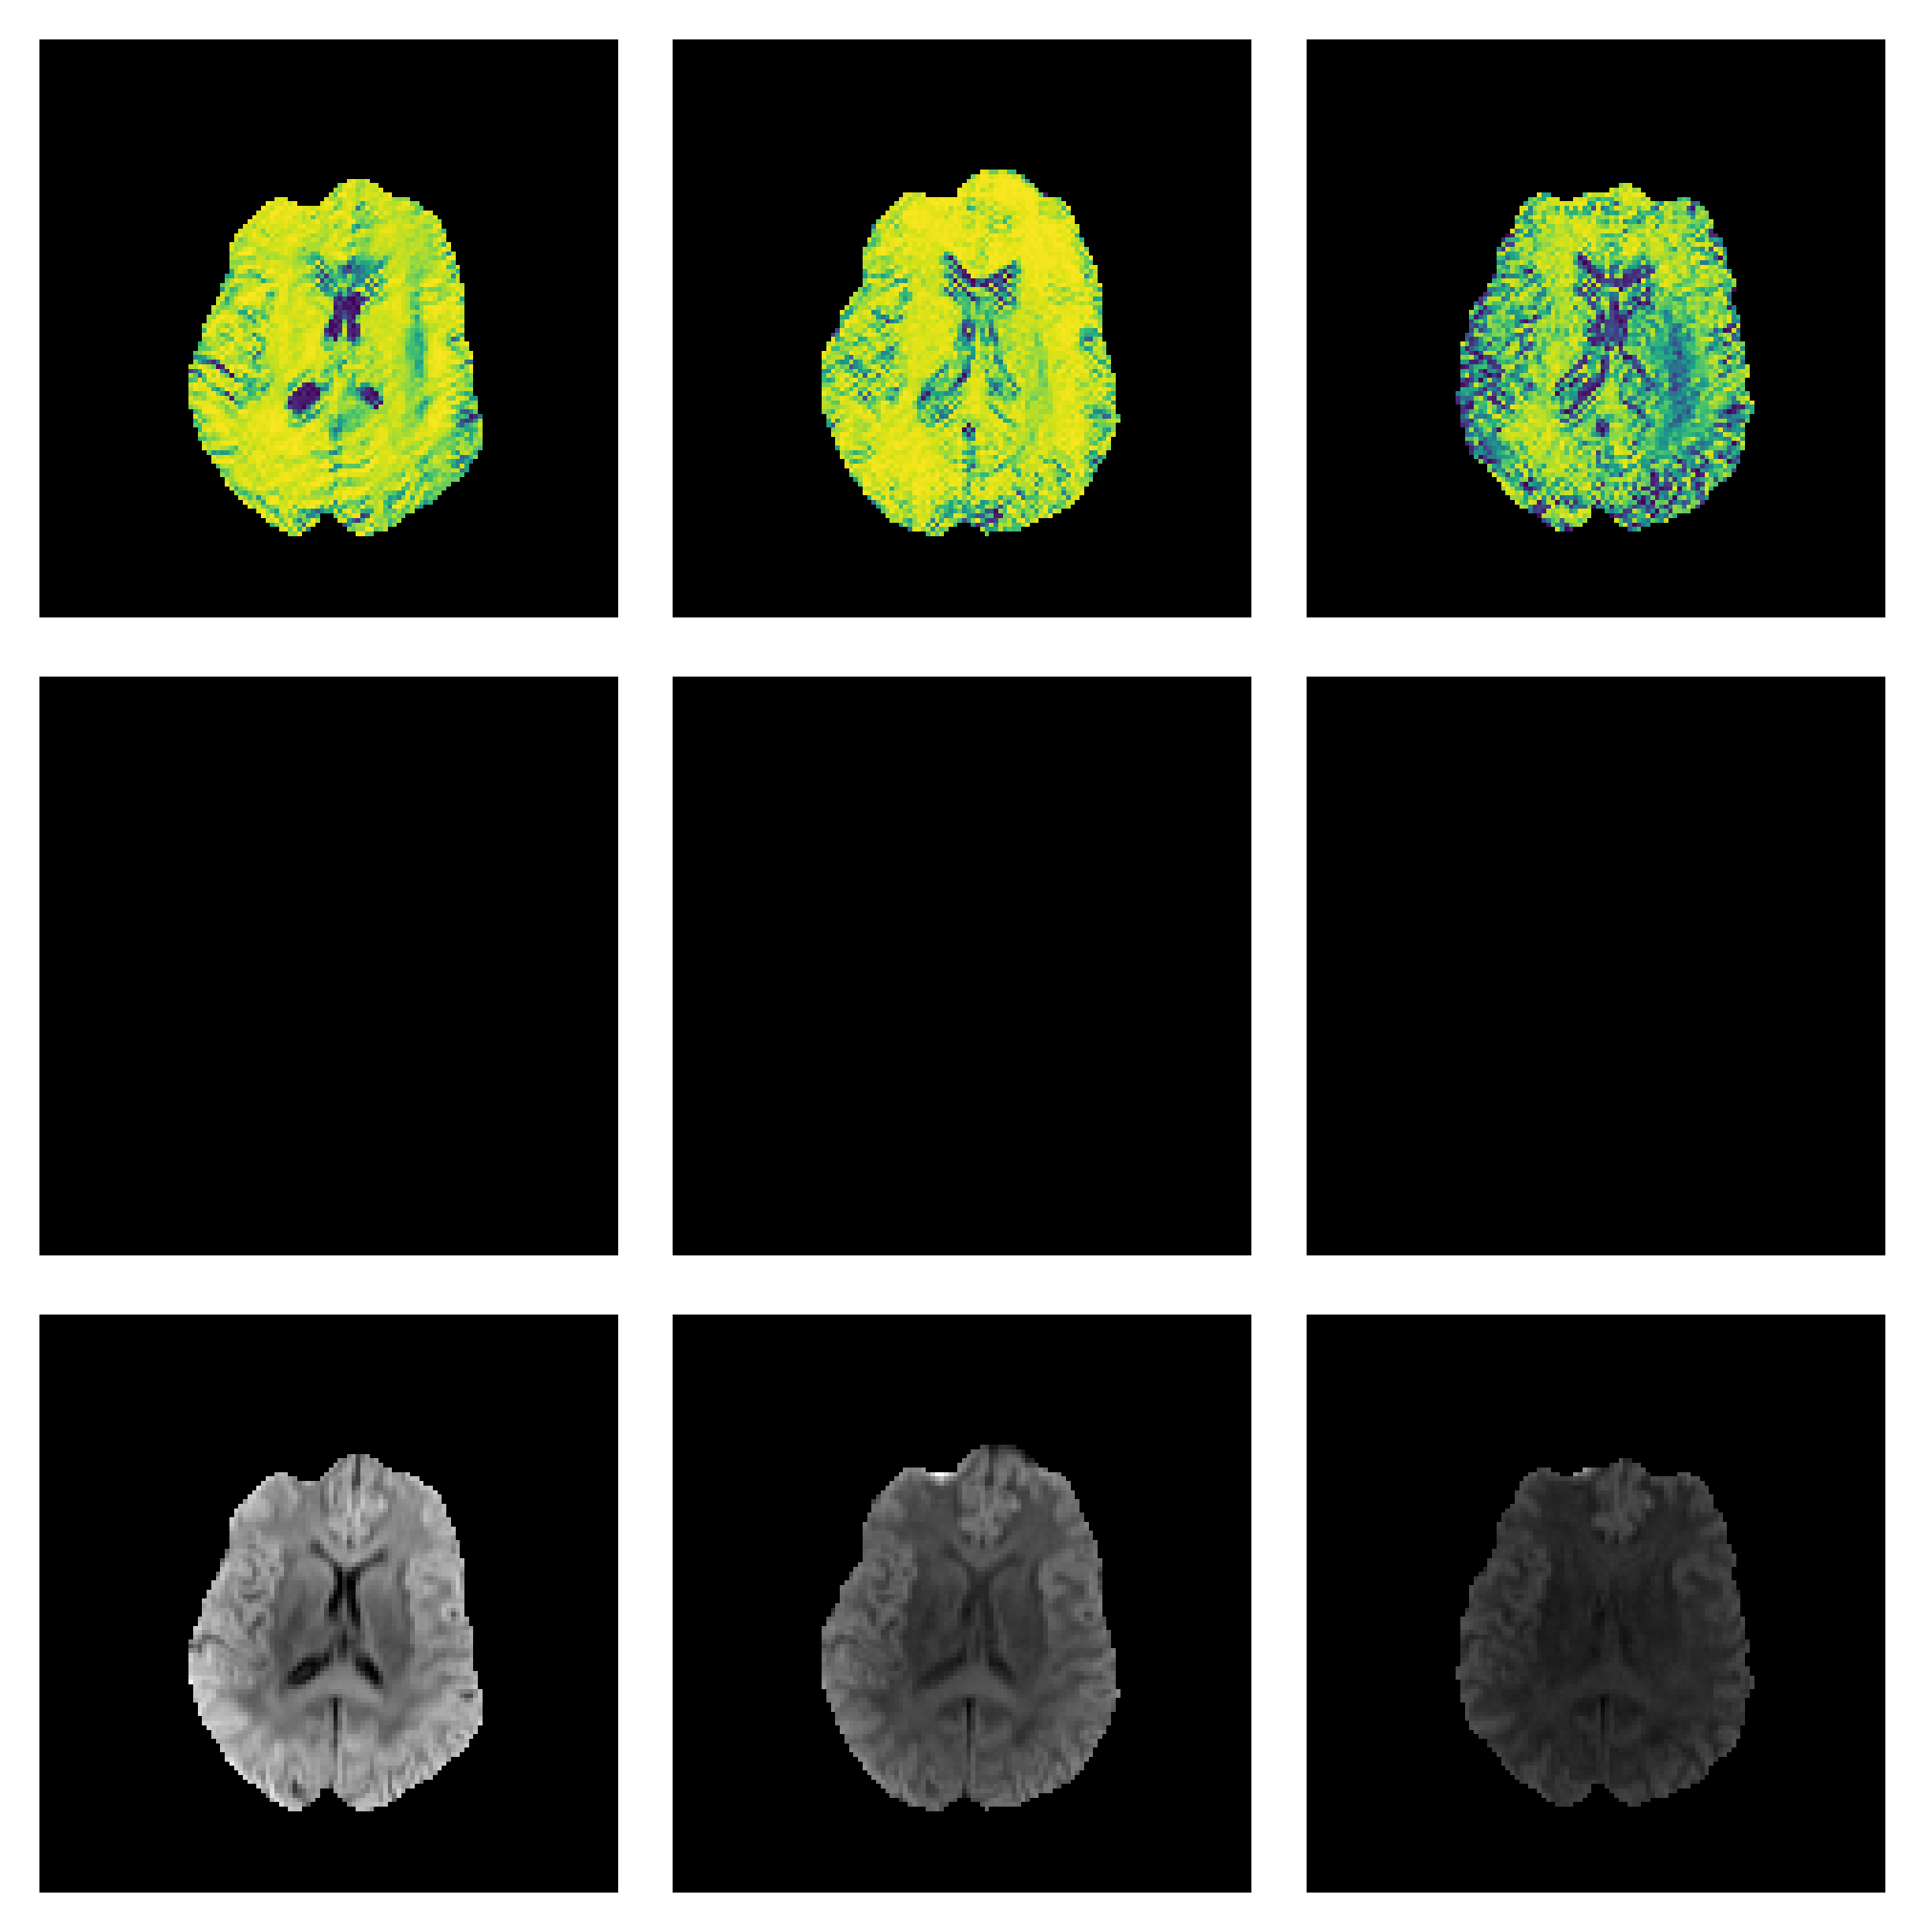

In [27]:
sl = 3
diffusion = -1 # diffusion direction [0, X [1], Y[2], Z[3]]
rep = -2
td = 2
volunteer = 0



fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(5,5), dpi=500)

w1 = 0 
w2 = 128
l1= 0
l2 = 128



M0_im = np.zeros((w2-w1,l2-l1))
M1_im = np.zeros((w2-w1,l2-l1))
M2_im = np.zeros((w2-w1,l2-l1))


### Get magnitude images
for ii in range(3):
    axes[ii,0].imshow(M0_im,vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')
    axes[ii,1].imshow(M1_im,vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')
    im0=axes[ii,2].imshow(M2_im,vmin = 0,vmax = 100,cmap = 'gray',interpolation = 'nearest')

vmax = 500


row = 0
color = 'viridis'
im_m0 = atten_m0[:,:,sl,diffusion,td,volunteer] *M0_mask[w1:w2,l1:l2,sl,volunteer]
im_m1 =  atten_m1[:,:,sl,diffusion,td,volunteer] *M1_mask[w1:w2,l1:l2,sl,volunteer]
im_m2 =  atten_m2[:,:,sl,diffusion,td,volunteer]*M2_mask[w1:w2,l1:l2,sl,volunteer]
axes[row,0].imshow(im_m0[w1:w2,l1:l2],vmin = 0,vmax = 1,cmap = color,interpolation = 'nearest')
axes[row,1].imshow(im_m1[w1:w2,l1:l2],vmin = 0,vmax = 1,cmap = color,interpolation = 'nearest')
im4=axes[row,2].imshow(im_m2[w1:w2,l1:l2],vmin = 0,vmax = 1,cmap = color,interpolation = 'nearest')
axes[row,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')

"""

row = 1
color = 'gray'
vmax = 500
im_m0 = abs(averaged_mag_M0[:,:,sl,diffusion,td,volunteer] *M0_mask[w1:w2,l1:l2,sl,volunteer])
im_m1 =  abs(averaged_mag_M1[:,:,sl,diffusion,td,volunteer] *M1_mask[w1:w2,l1:l2,sl,volunteer])
im_m2 =  abs( averaged_mag_M2[:,:,sl,diffusion,td,volunteer]*M2_mask[w1:w2,l1:l2,sl,volunteer])
axes[row,0].imshow(im_m0[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[row,1].imshow(im_m1[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
im4=axes[row,2].imshow(im_m2[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[row,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')

"""

row = 2
color = 'gray'
im_m0 = np.real(averaged_complex_M0[:,:,sl,diffusion,td,volunteer] *M0_mask[w1:w2,l1:l2,sl,volunteer])
im_m1 =   np.real(averaged_complex_M1[:,:,sl,diffusion,td,volunteer] *M1_mask[w1:w2,l1:l2,sl,volunteer])
im_m2 =   np.real(averaged_complex_M2[:,:,sl,diffusion,td,volunteer]*M2_mask[w1:w2,l1:l2,sl,volunteer])

axes[row,0].imshow(im_m0[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[row,1].imshow(im_m1[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
im4=axes[row,2].imshow(im_m2[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[row,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')





for ii in range(3):
    for jj in range(3):
        axes[ii,jj].axis('off')

plt.tight_layout()



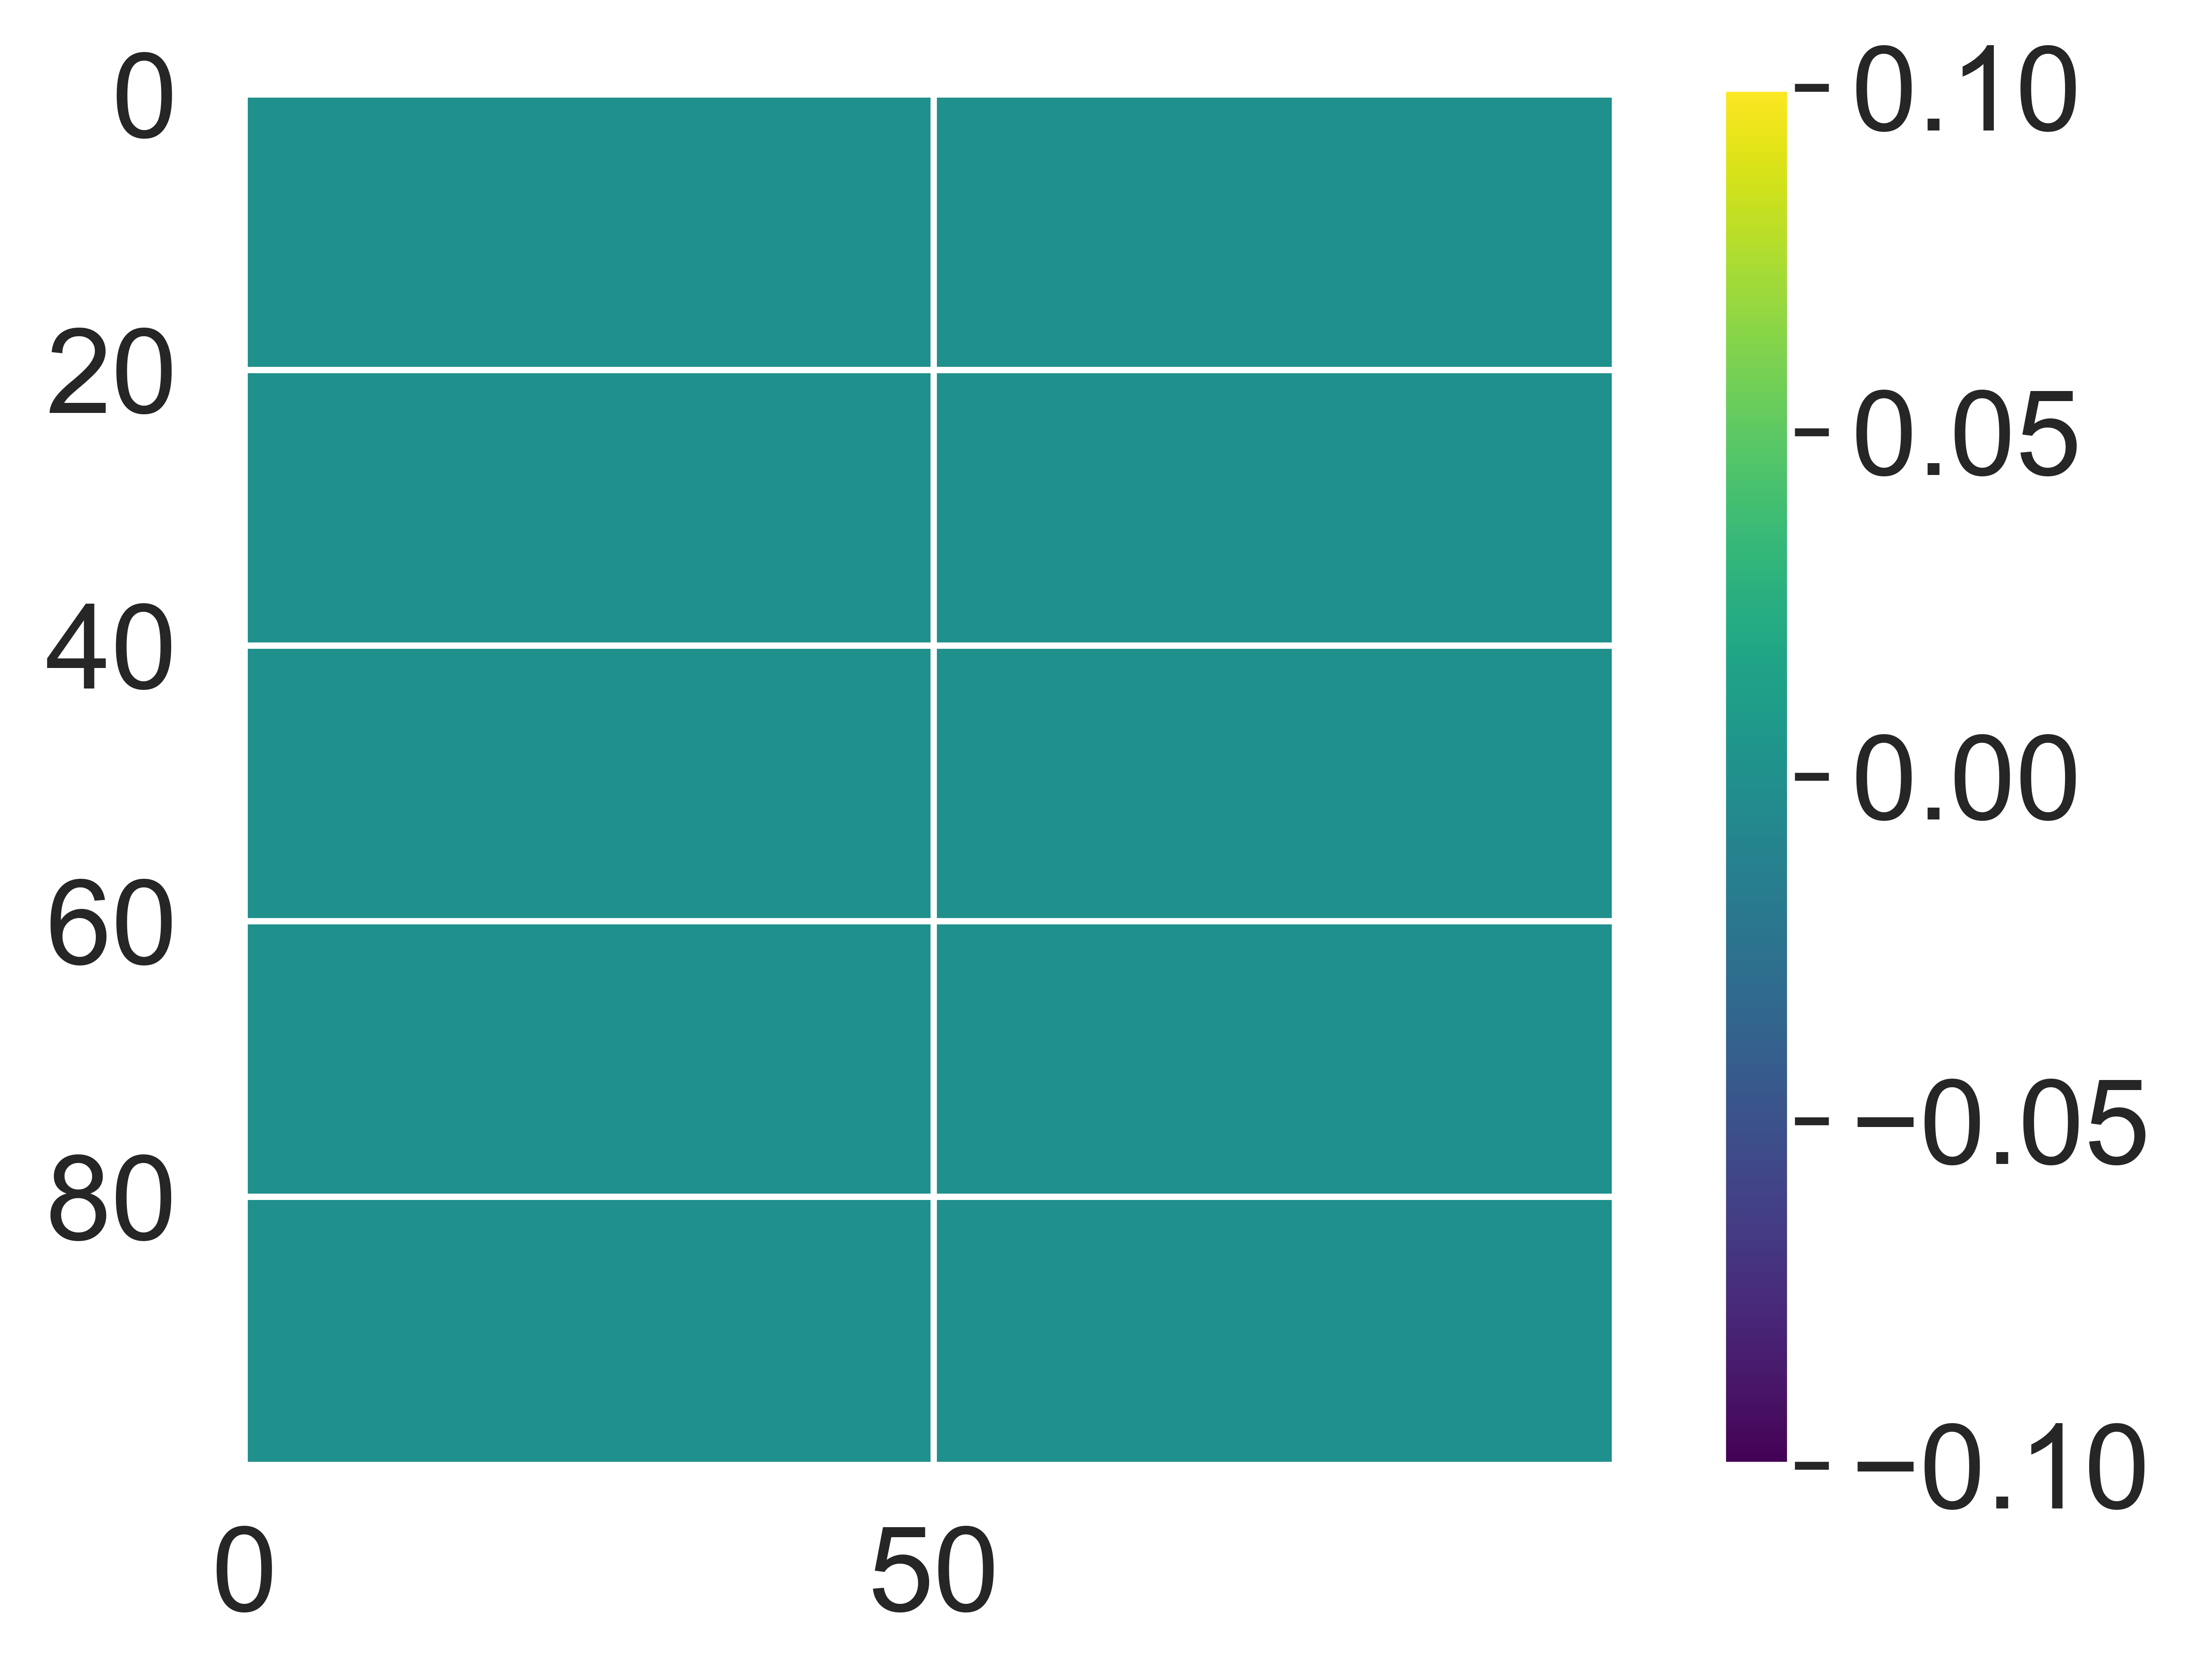

In [ ]:
plt.figure(dpi = 1000)
plt.imshow(np.zeros((100,100)),cmap = 'viridis')
plt.colorbar()

# Average Signal Attenuation

In [28]:
M0_avg = atten_m0
M1_avg = atten_m1
M2_avg = atten_m2

M0_avg_mean = np.nanmean(M0_avg*M0_mask_new[:,:,:,np.newaxis,np.newaxis], axis = (0,1))
M1_avg_mean = np.nanmean(M1_avg*M1_mask_new[:,:,:,np.newaxis,np.newaxis], axis = (0,1))
M2_avg_mean = np.nanmean(M2_avg*M2_mask_new[:,:,:,np.newaxis,np.newaxis], axis = (0,1))


avg_all = np.stack((M0_avg_mean,M1_avg_mean,M2_avg_mean),axis = -1)
avg_mean = np.nanmean(avg_all,axis = -2)
M0_avg_mean.shape


(6, 4, 8, 10)

# ADC Complex Average vs. Magnitude

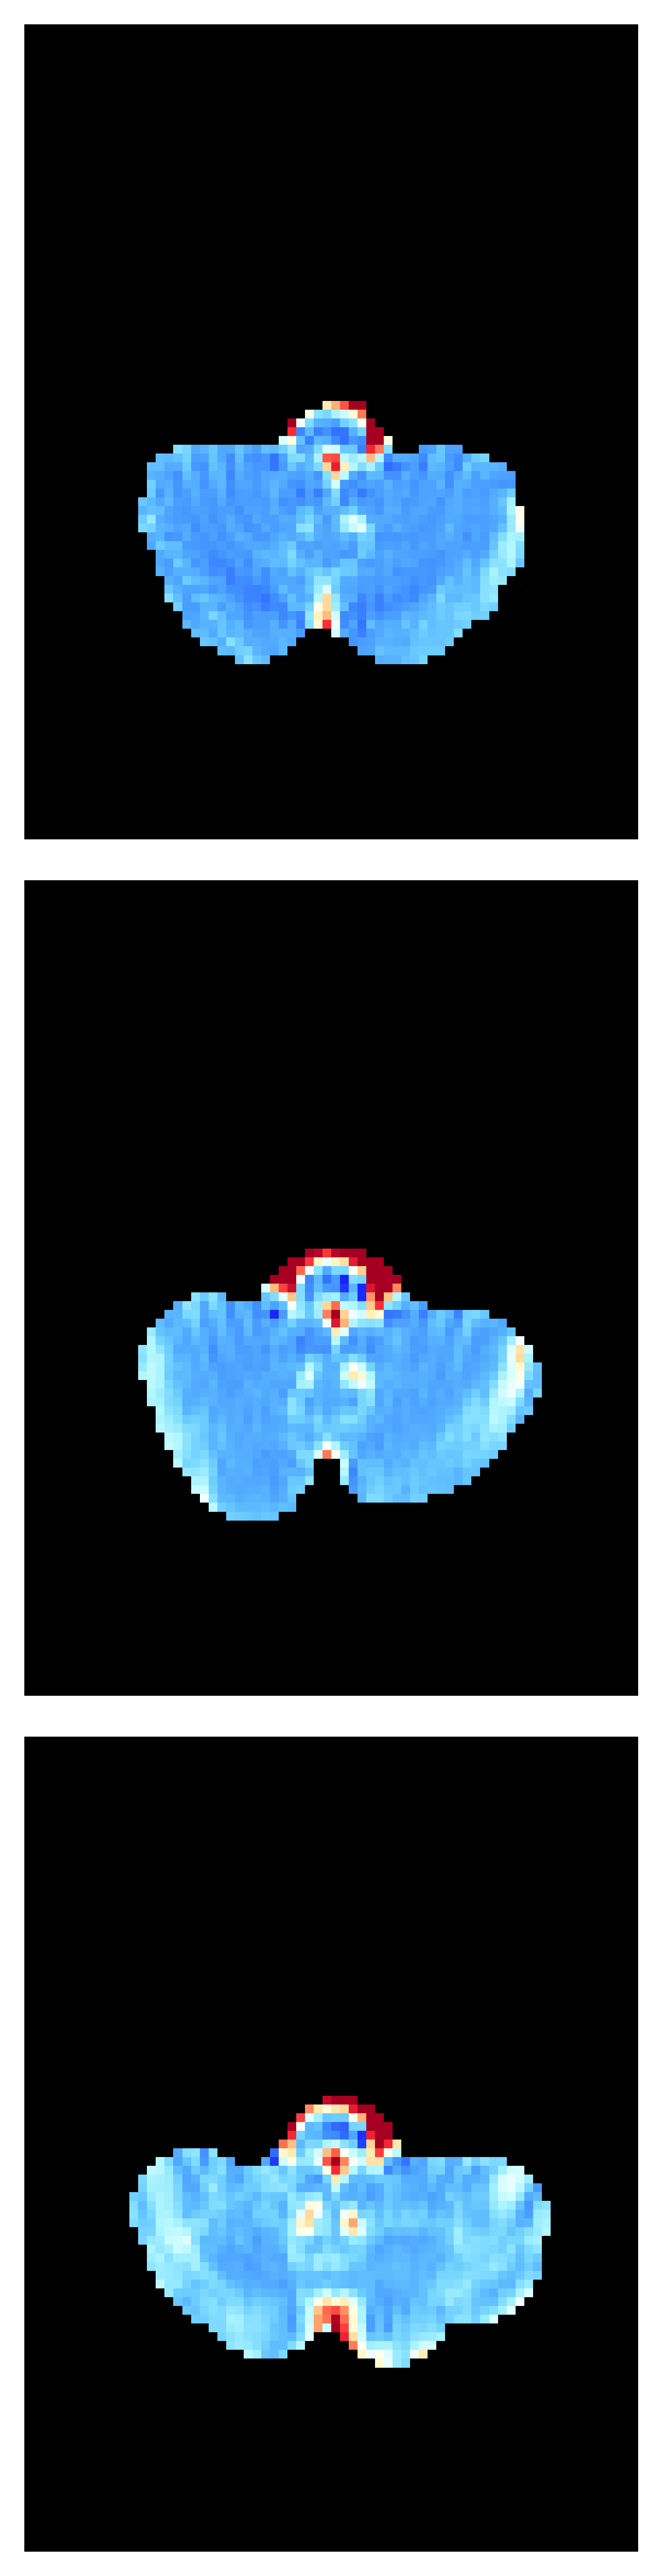

In [73]:
sl = 0
diffusion = -1 # diffusion direction [0, X [1], Y[2], Z[3]]
rep = -2
td = 2
volunteer = 2



fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(5,11), dpi=500)

w1 = 17 
w2 = 110
l1= 30
l2 = 100



M0_im = np.zeros((128,128)) #abs(averaged_mag_M0[:,:,sl,diffusion,td,volunteer])
M1_im =  np.zeros((128,128)) #abs(averaged_mag_M1[:,:,sl,diffusion,td,volunteer])
M2_im =  np.zeros((128,128)) #abs(averaged_mag_M2[:,:,sl,diffusion,td,volunteer])


### Get magnitude images
for ii in range(1):
    axes[0].imshow(M0_im[w1:w2,l1:l2],vmin = 0,vmax = 120,cmap = 'gray',interpolation = 'nearest')
    axes[1].imshow(M1_im[w1:w2,l1:l2],vmin = 0,vmax = 120,cmap = 'gray',interpolation = 'nearest')
    im0=axes[2].imshow(M2_im[w1:w2,l1:l2],vmin = 0,vmax = 120,cmap = 'gray',interpolation = 'nearest')


"""

row = 0
color = cDTI_cmaps['MD']

im_m0 = abs(adc_mag_M0[:,:,sl,volunteer] *M0_mask[:,:,sl,volunteer])
im_m1 =  abs(adc_mag_M1[:,:,sl,volunteer] *M1_mask[:,:,sl,volunteer])
im_m2 =  abs( adc_mag_M2[:,:,sl,volunteer]*M2_mask[:,:,sl,volunteer])
axes[row,0].imshow(im_m0[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[row,1].imshow(im_m1[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
im4=axes[row,2].imshow(im_m2[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[row,0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[row,2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')



row = 1
"""
vmax = 3
color = cDTI_cmaps['MD']
im_m0 = np.real(adc_complex_M0[:,:,sl,td,volunteer] *M0_mask[:,:,sl,volunteer])
im_m1 =   np.real(adc_complex_M1[:,:,sl,td,volunteer] *M1_mask[:,:,sl,volunteer])
im_m2 =   np.real(adc_complex_M2[:,:,sl,td,volunteer]*M2_mask[:,:,sl,volunteer])

axes[0].imshow(im_m0[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[1].imshow(im_m1[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
im4=axes[2].imshow(im_m2[w1:w2,l1:l2],vmin = 0,vmax = vmax,cmap = color,interpolation = 'nearest')
axes[0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
axes[2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,volunteer])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')





for ii in range(2):
    for jj in range(3):
        axes[jj].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace =0.05)

# ADC Complex Average vs. Magnitude

In [30]:
from sklearn.linear_model import LinearRegression
adc_complex_M0 = adc_complex_M0 *M0_mask[:,:,:,np.newaxis,:]
adc_complex_M1 = adc_complex_M1 *M1_mask[:,:,:,np.newaxis,:]
adc_complex_M2 = adc_complex_M2 *M2_mask[:,:,:,np.newaxis,:]

In [ ]:
adc_mag_M0.shape

(128, 128, 6, 8, 10)

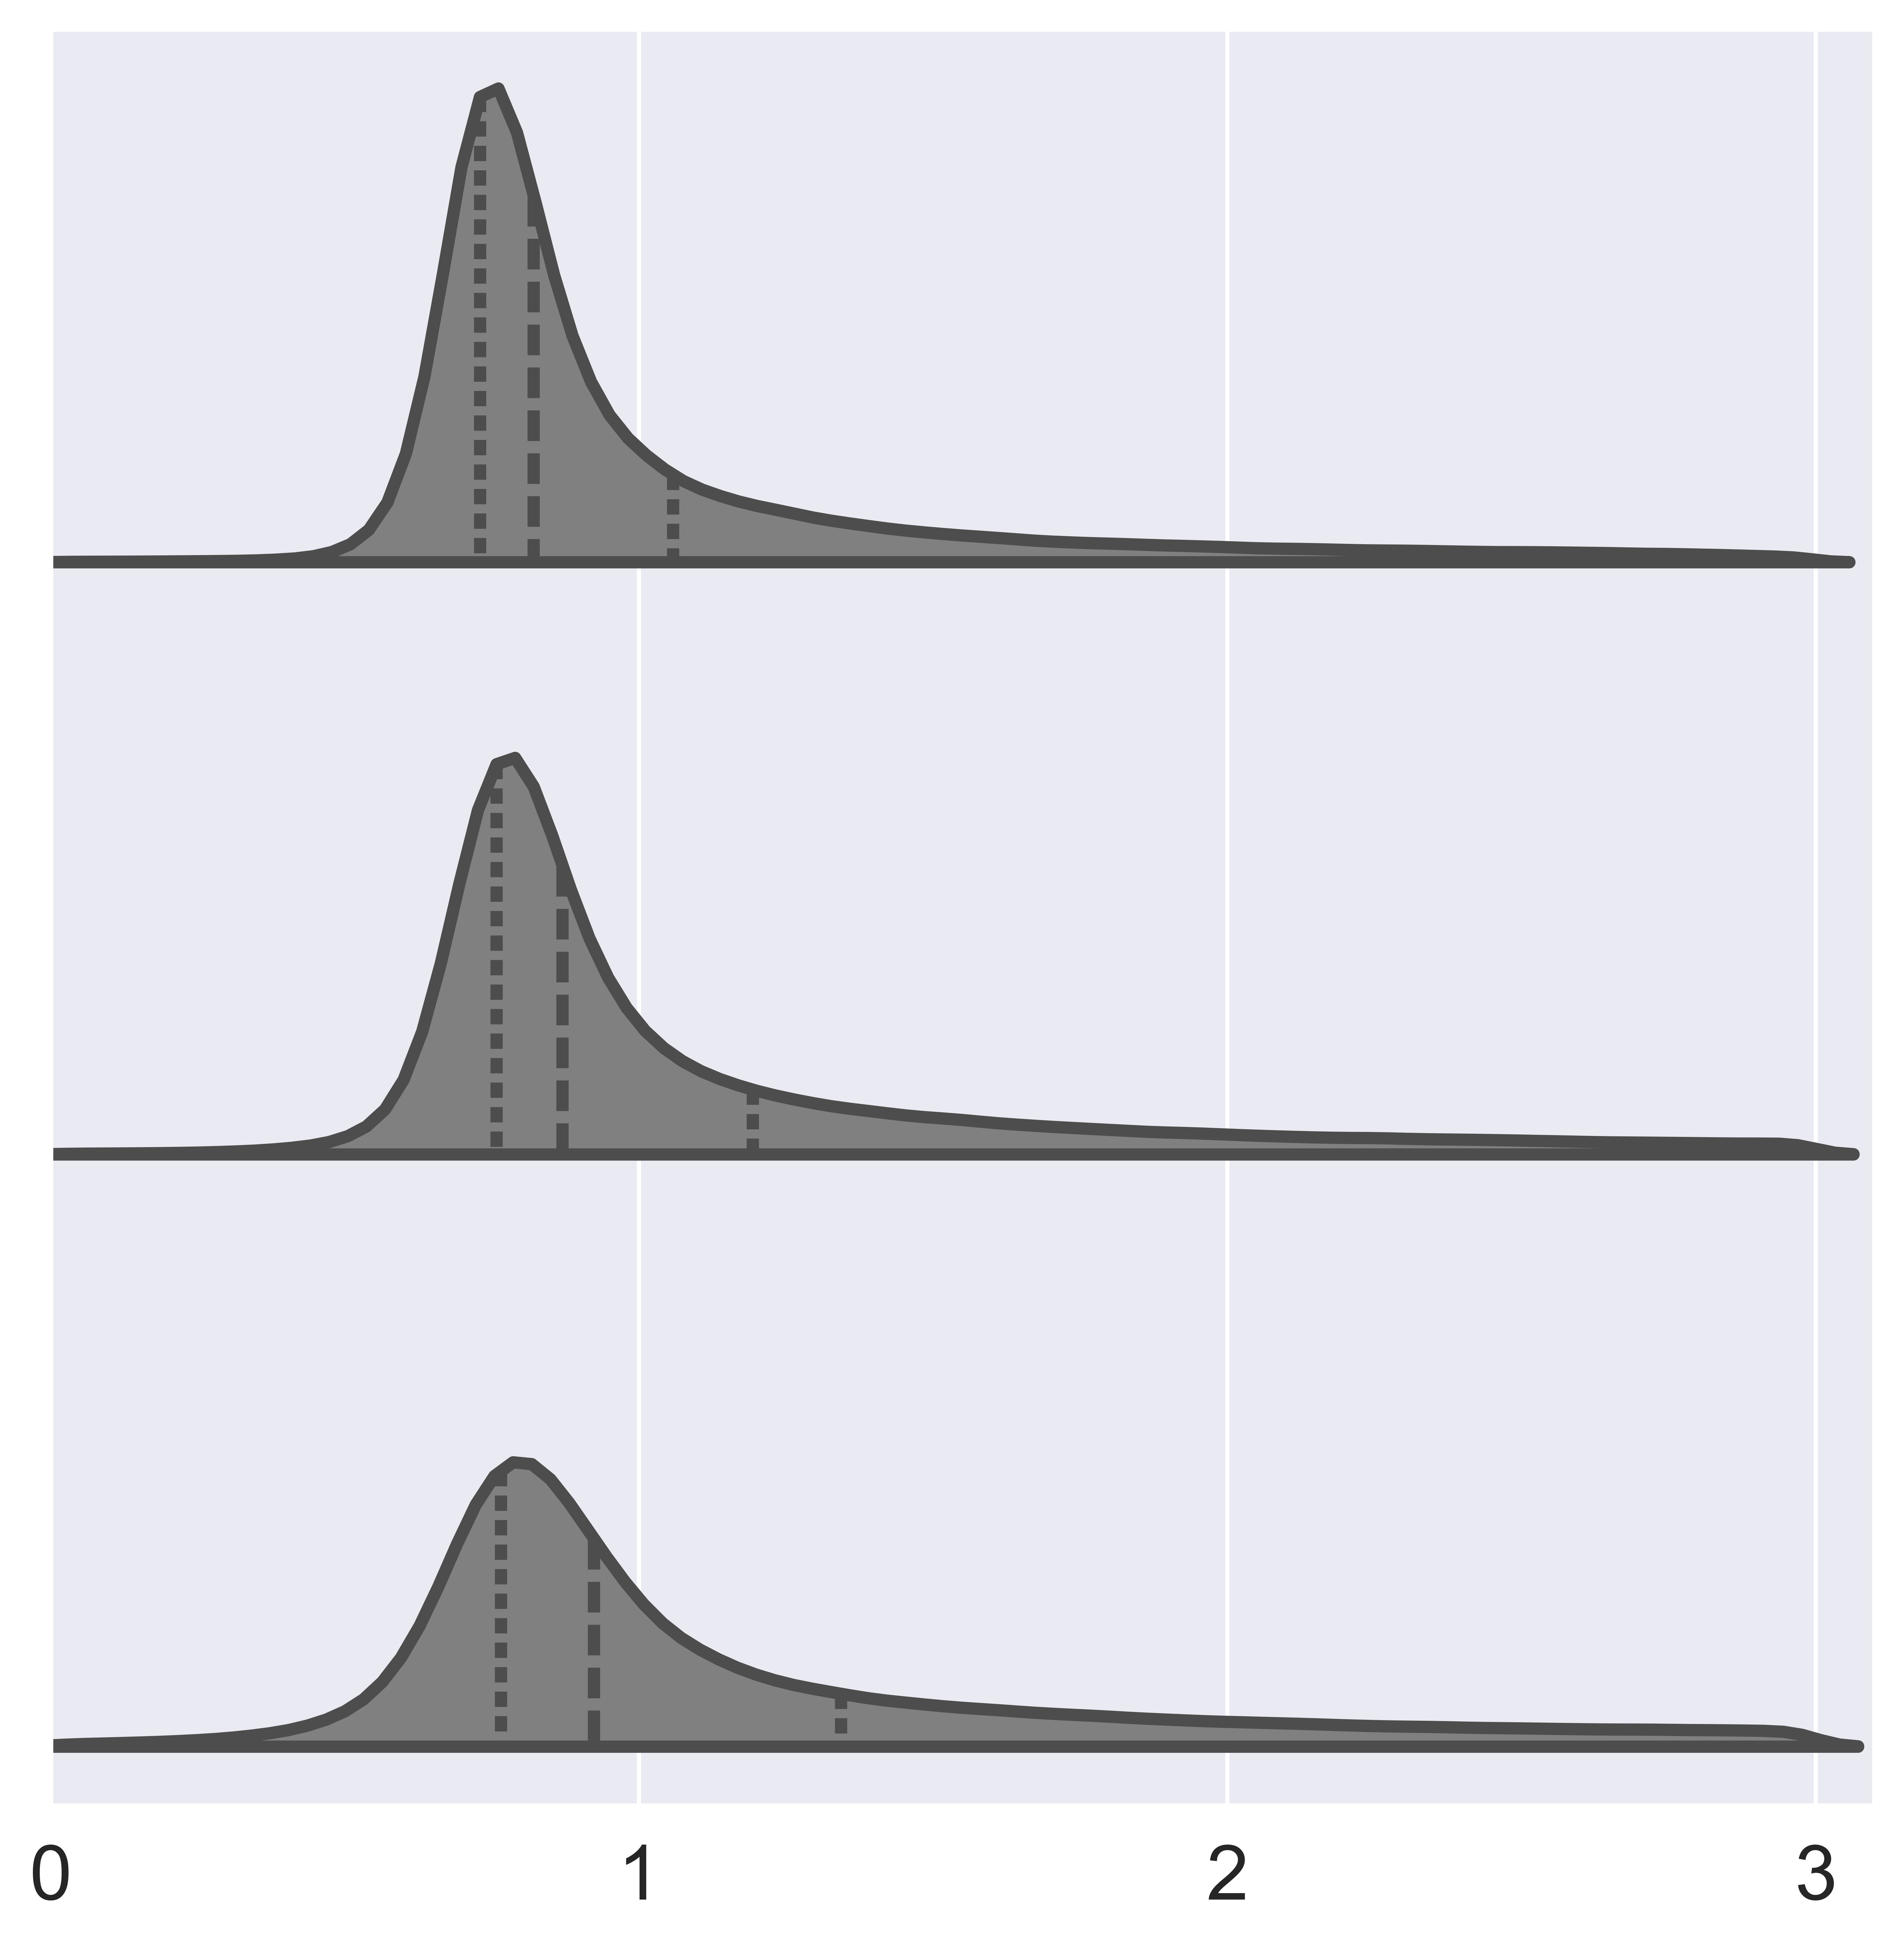

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sl = range(6)
td = range(8)
sns.set_palette('colorblind')
sns.set(font_scale=1.7) 
# Function to flatten and pad arrays to the same size, excluding values > 3 or == 0
def flatten_and_pad(array, target_size):
    flat_array = array.ravel()
    flat_array = flat_array[(flat_array <= 3) & (flat_array != 0)]  # Filter values
    padding = np.full(target_size - len(flat_array), np.nan)
    return np.concatenate([flat_array, padding])

# Prepare data for DataFrame
data = {
    'Method': 
              ['Complex'] * adc_complex_M0.size +
             
              ['Complex'] * adc_complex_M1.size +
             
              ['Complex'] * adc_complex_M2.size,
    'Value': np.concatenate([
        flatten_and_pad(adc_complex_M0*M0_mask[:,:,:,np.newaxis,:], adc_complex_M0.size),
        flatten_and_pad(adc_complex_M1*M1_mask[:,:,:,np.newaxis,:], adc_complex_M1.size),
        flatten_and_pad(adc_complex_M2*M2_mask[:,:,:,np.newaxis,:], adc_complex_M2.size)
    ]),
    'Case': ['M$_0$'] * (adc_complex_M0.size) + 
            ['M$_1$'] * (adc_complex_M1.size) + 
            ['M$_1$ + M$_2$'] * (adc_complex_M2.size)
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(8, 8),dpi = 1000)
sns.violinplot(data=df, y="Case", x="Value", split= True,  inner="quart",orient  = 'h' , linewidth =3,color = 'gray')
plt.ylabel('',size = 1)
plt.xlabel('',size = 1)
plt.yticks([])
plt.xticks([0,1,2,3,4])


plt.xlim([0,3.1])
plt.show()


In [54]:
std_all.shape

(128, 128, 6, 8, 10, 3)

In [65]:
adc_complex_M0.shape

med_adc_complex_M0 = adc_complex_M0 #np.nanmean(adc_complex_M0,axis = (0,1))
med_adc_complex_M1 = adc_complex_M1 #np.nanmean(adc_complex_M1,axis = (0,1))
med_adc_complex_M2 = adc_complex_M2 #np.nanmean(adc_complex_M2,axis = (0,1))

std_all = np.stack((med_adc_complex_M0,med_adc_complex_M1,med_adc_complex_M2),axis = -1)
std_all.shape


alpha = 0.5


import scikit_posthocs as sp
from scipy import stats
group1 = std_all[:,:,:,:,:,0].reshape((6*8*10*128*128))
group2 = std_all[:,:,:,:,:,1].reshape((6*8*10*128*128))
group3 = std_all[:,:,:,:,:,2].reshape((6*8*10*128*128))

combo = np.stack((group1,group2,group3),axis = -1)
for i in range(3):
    nan_indices = np.isnan(combo[..., i])
    combo[nan_indices,:] = np.nan

# Separate arrays
med_adc_complex_M0 = combo[..., 0]
med_adc_complex_M1 = combo[..., 1]
med_adc_complex_M2 = combo[..., 2]

# Reshape the groups
group1 = med_adc_complex_M0.reshape((-1,))
group2 = med_adc_complex_M1.reshape((-1,))
group3 = med_adc_complex_M2.reshape((-1,))

group1 = group1[~np.isnan(group1)][:100]
group2 = group2[~np.isnan(group2)][:100]
group3 = group3[~np.isnan(group3)][:100]


normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

if normal ==0:
    result = stats.friedmanchisquare(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
        hypothesis = test
    else:
        hypothesis = np.nan

elif normal ==1:
    result = stats.f_oneway(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
        hypothesis= test 
    else:
        hypothesis = np.nan

hypothesis

,1,2,3
1,1.000000e+00,0.000027,2.197969e-08
2,2.729184e-05,1.000000,1.487119e-01
3,2.197969e-08,0.148712,1.000000e+00


In [63]:
group1.shape

(1084224,)

In [57]:

# Combine all arrays into a single array
combined_array = np.stack((adc_complex_M0, adc_complex_M1, adc_complex_M2), axis=-1)

# Iterate over each array and filter NaNs
for i in range(3):
    nan_indices = np.isnan(combined_array[..., i])
    combined_array[nan_indices,:] = np.nan

# Separate arrays
med_adc_complex_M0 = combined_array[..., 0]
med_adc_complex_M1 = combined_array[..., 1]
med_adc_complex_M2 = combined_array[..., 2]

# Reshape the groups
group1 = med_adc_complex_M0.reshape((-1,))
group2 = med_adc_complex_M1.reshape((-1,))
group3 = med_adc_complex_M2.reshape((-1,))

group1 = group1[~np.isnan(group1)]
group2 = group2[~np.isnan(group2)]
group3 = group3[~np.isnan(group3)]

(128, 128, 6, 8, 10)

In [66]:
adc_complex_M0.shape

med_adc_complex_M0 = np.nanmean(adc_complex_M0,axis = (0,1,2,3))
med_adc_complex_M1 = np.nanmean(adc_complex_M1,axis = (0,1,2,3))
med_adc_complex_M2 = np.nanmean(adc_complex_M2,axis = (0,1,2,3))

std_all = np.stack((med_adc_complex_M0,med_adc_complex_M1,med_adc_complex_M2),axis = -1)
std_all.shape

alpha = 0.5


import scikit_posthocs as sp
from scipy import stats
group1 = std_all[:,0]
group2 = std_all[:,1]
group3 = std_all[:,2]

normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

if normal ==0:
    result = stats.friedmanchisquare(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
        hypothesis = test
    else:
        hypothesis = np.nan

elif normal ==1:
    result = stats.f_oneway(group1, group2, group3)
    if result[1] < alpha:
        test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
        hypothesis= test 
    else:
        hypothesis = np.nan

hypothesis

,1,2,3
1,1.000000,0.052135,0.001952
2,0.052135,1.000000,0.120640
3,0.001952,0.120640,1.000000


In [40]:
# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((6,8,3,3))
hypothesis[:] = np.nan

slices = [5,4,3,2,1,0]
for sl in range(6):
    for dd in range(8):
        group1 = std_all[slices[sl],dd,:,0]
        group2 = std_all[slices[sl],dd,:,1]
        group3 = std_all[slices[sl],dd,:,2]

        normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


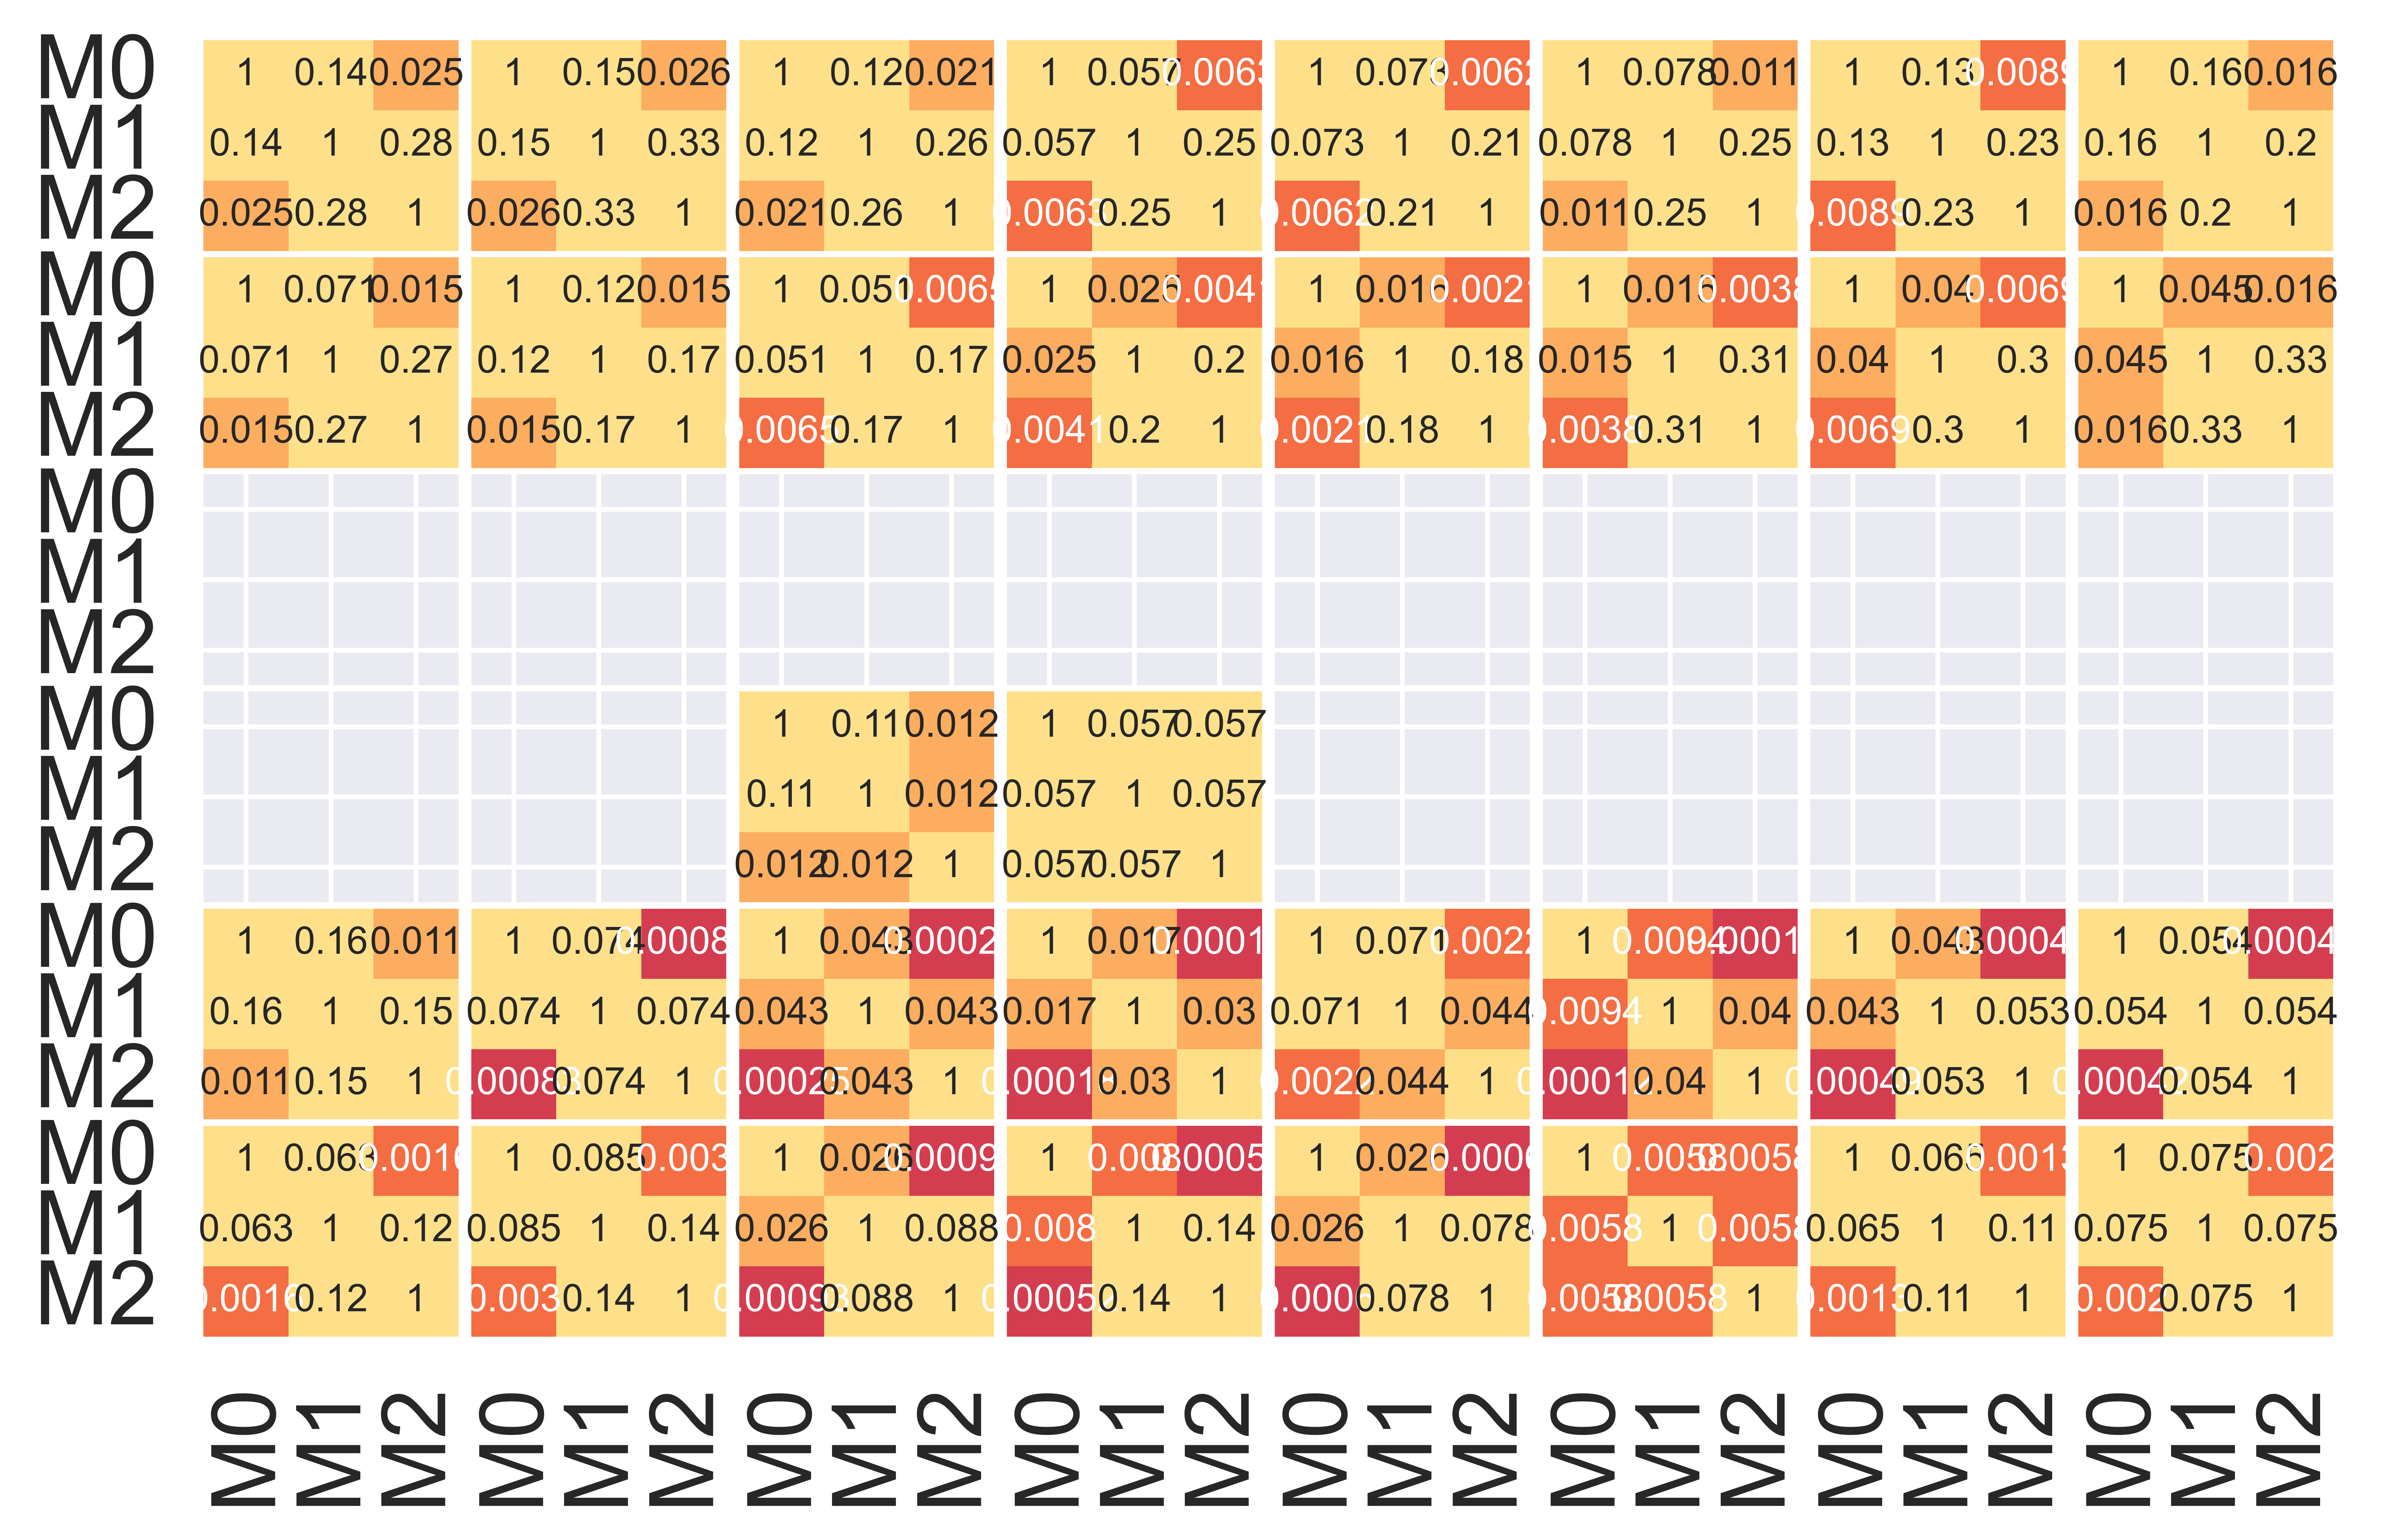

In [42]:
from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(6, 8, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(6):
    for dirs in range(8):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)




<ipython-input-73-8a1cbd4da6a0>:1: RuntimeWarning: invalid value encountered in divide
  test = np.nanmean(abs(im_M0),axis = (-2,-3)) / np.nanstd(abs(im_M0),axis = (-2,-3))


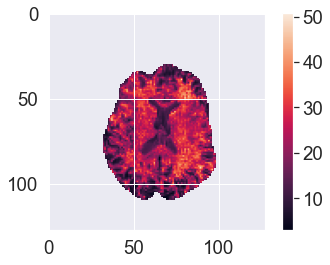

21.051026547177393


<ipython-input-73-8a1cbd4da6a0>:10: RuntimeWarning: invalid value encountered in divide
  test = np.nanmean(abs(im_M1),axis = (-2,-3)) / np.nanstd(abs(im_M1),axis = (-2,-3))


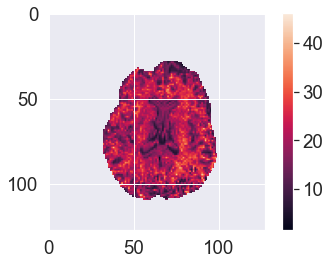

19.553518829898795


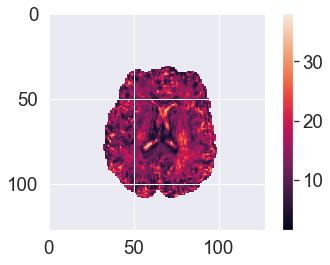

13.908024564359609


In [ ]:
snr_m0 = np.nanmean(abs(im_M0),axis = (-2,-3)) / np.nanstd(abs(im_M0),axis = (-2,-3)) 


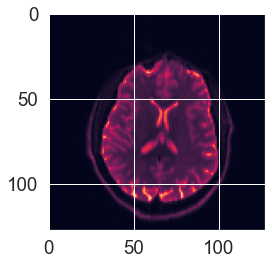

In [ ]:
plt.imshow(abs(im_M0[:,:,3,0,0,0,0]))

In [67]:
median_per_group = df.groupby('Case')['Value'].median()
print("Median value for each group:")
print(median_per_group)
percentiles_per_group = df.groupby('Case')['Value'].quantile([0.025, 0.975])

Median value for each group:
Case
M$_0$            0.821092
M$_1$            0.870182
M$_1$ + M$_2$    0.923643
Name: Value, dtype: float64


In [71]:
percentiles_per_group = df.groupby('Case')['Value'].quantile([0.25, 0.75])

In [72]:
percentiles_per_group

Case               
M$_0$          0.25    0.729809
               0.75    1.058124
M$_1$          0.25    0.758094
               0.75    1.193576
M$_1$ + M$_2$  0.25    0.765642
               0.75    1.343337
Name: Value, dtype: float64